In [1]:
# Human Activity Recognition (HAR) using WISDM Dataset

# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 2. Load Dataset
file_path = "C:\CAPSTONE\WISDM_at_latest\home\share\data\public_sets\WISDM_at_v2.0\WISDM_at_v2.0_raw.txt"
data = pd.read_csv(file_path, header=None, names=['user', 'activity', 'timestamp', 'x', 'y', 'z'])


In [3]:
# 3. Preprocessing
data.dropna(inplace=True)


In [4]:
# Convert 'z' column to numeric, handling the case where it contains multiple values separated by semicolons
def convert_to_numeric(value):
    if pd.isna(value) or value.strip() == '':
        return np.nan
    try:
        return float(value)
    except ValueError:
        values = value.split(';')
        return np.mean([float(v) for v in values if v.strip() != ''])

data['z'] = data['z'].apply(convert_to_numeric)
data.dropna(subset=['z'], inplace=True)

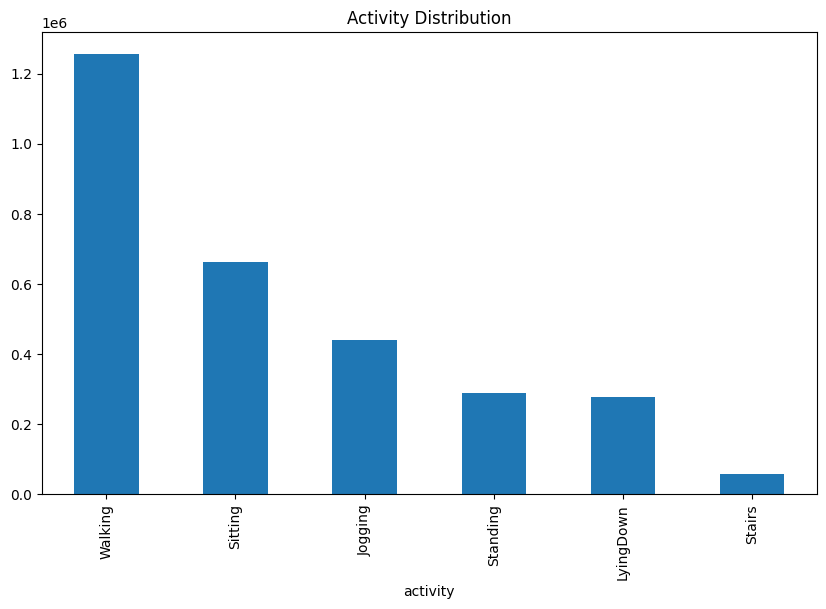

In [5]:
# 4. EDA
plt.figure(figsize=(10,6))
data['activity'].value_counts().plot(kind='bar')
plt.title('Activity Distribution')
plt.show()

In [6]:
# 5. Windowing and Feature Engineering
def feature_extraction(df, window_size=50):
    features = []
    for start in range(0, len(df) - window_size, window_size):
        end = start + window_size
        window = df.iloc[start:end]
        if len(window['activity'].value_counts()) == 1:
            feature_dict = {
                'mean_x': window['x'].mean(),
                'mean_y': window['y'].mean(),
                'mean_z': window['z'].mean(),
                'std_x': window['x'].std(),
                'std_y': window['y'].std(),
                'std_z': window['z'].std(),
                'min_x': window['x'].min(),
                'min_y': window['y'].min(),
                'min_z': window['z'].min(),
                'max_x': window['x'].max(),
                'max_y': window['y'].max(),
                'max_z': window['z'].max(),
                'skew_x': skew(window['x']),
                'skew_y': skew(window['y']),
                'skew_z': skew(window['z']),
                'kurt_x': kurtosis(window['x']),
                'kurt_y': kurtosis(window['y']),
                'kurt_z': kurtosis(window['z']),
                'resultant_accel': np.sqrt(window['x']**2 + window['y']**2 + window['z']**2).mean(),
                'activity': window['activity'].iloc[0]
            }
            features.append(feature_dict)
    return pd.DataFrame(features)

features_df = feature_extraction(data)

In [7]:
# 6. Normalize and Impute
X = features_df.drop('activity', axis=1)
y = features_df['activity']

In [8]:
# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [9]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


In [10]:
# 7. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)


In [11]:
# 8. Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression F1 Score:", f1_score(y_test, y_pred_lr, average='weighted'))


Logistic Regression Accuracy: 0.7272112294943345
Logistic Regression F1 Score: 0.7090330435417457


In [12]:
# 9. Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest F1 Score:", f1_score(y_test, y_pred_rf, average='weighted'))


Random Forest Accuracy: 0.9612717740571621
Random Forest F1 Score: 0.9608341234091922


In [13]:

from sklearn.preprocessing import LabelEncoder

# Encode both training and test labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train XGBoost with encoded labels
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train_encoded)

# Predict and evaluate on encoded test set
y_pred_xgb_encoded = xgb.predict(X_test)

# Now compare encoded test labels with encoded predictions
print("XGBoost Accuracy:", accuracy_score(y_test_encoded, y_pred_xgb_encoded))
print("XGBoost F1 Score:", f1_score(y_test_encoded, y_pred_xgb_encoded, average='weighted'))

# Optional: Decode predictions back to original activity names if needed
y_pred_xgb_labels = label_encoder.inverse_transform(y_pred_xgb_encoded)


XGBoost Accuracy: 0.9603416201589717
XGBoost F1 Score: 0.9601104550373121


In [14]:
# 11. Deep Learning (Keras)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(np.unique(y_train_encoded)), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train_encoded, epochs=30, batch_size=64, validation_split=0.2, callbacks=[early_stop])


Epoch 1/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6302 - loss: 1.1086 - val_accuracy: 0.7821 - val_loss: 0.5761
Epoch 2/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7573 - loss: 0.6590 - val_accuracy: 0.8047 - val_loss: 0.5083
Epoch 3/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7768 - loss: 0.5981 - val_accuracy: 0.8038 - val_loss: 0.4791
Epoch 4/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7856 - loss: 0.5647 - val_accuracy: 0.8146 - val_loss: 0.4595
Epoch 5/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7958 - loss: 0.5338 - val_accuracy: 0.8217 - val_loss: 0.4441
Epoch 6/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7966 - loss: 0.5207 - val_accuracy: 0.8225 - val_loss: 0.4336
Epoch 7/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8000 - loss: 0.5018 - val_accuracy: 0.8269 - val_loss: 0.4290
Epoch 8/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8043 - loss: 0.4988 - val_accuracy: 0.

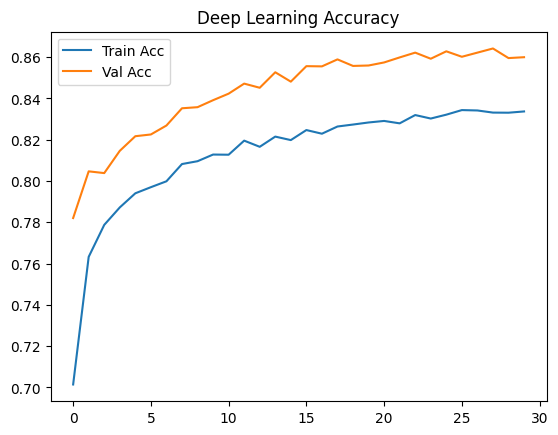

In [15]:
# Plot loss and accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Deep Learning Accuracy')
plt.show()


In [16]:
# Deep learning predictions
y_pred_dl = model.predict(X_test)
y_pred_dl_classes = np.argmax(y_pred_dl, axis=1)
print("Deep Learning Accuracy:", accuracy_score(y_test_encoded, y_pred_dl_classes))
print("Deep Learning F1 Score:", f1_score(y_test_encoded, y_pred_dl_classes, average='weighted'))


370/370 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Deep Learning Accuracy: 0.8556570268899036
Deep Learning F1 Score: 0.854152748933947


In [17]:
# Define unlabeled_df using the existing data dataframe
unlabeled_df = data[['x', 'y', 'z']].rename(columns={'x': 'x_acceleration', 'y': 'y_acceleration', 'z': 'z_acceleration'})

# Compute statistical features for the entire dataset
unlabeled_features = unlabeled_df.agg({
    "x_acceleration": ["mean", "std", "min", "max"],
    "y_acceleration": ["mean", "std", "min", "max"],
    "z_acceleration": ["mean", "std", "min", "max"],
}).reset_index()

# Rename columns for clarity
unlabeled_features.columns = ["_".join(col).strip() for col in unlabeled_features.columns.values]

# Show extracted features
print(unlabeled_features.head())


  i_n_d_e_x  x___a_c_c_e_l_e_r_a_t_i_o_n  y___a_c_c_e_l_e_r_a_t_i_o_n  \
0      mean                 4.844853e+10                -1.373680e+05   
1       std                 8.364586e+13                 2.371697e+08   
2       min                -4.628739e+01                -4.094710e+11   
3       max                 1.444137e+17                 8.013994e+01   

   z___a_c_c_e_l_e_r_a_t_i_o_n  
0                 1.984417e+14  
1                 3.426074e+17  
2                -4.820949e+01  
3                 5.915081e+20  



### Explanation for Random Forest Visualizations

**Confusion Matrix:**  
- This heatmap shows how well the model predicted each activity.  
- Darker diagonal cells indicate correct predictions, while off-diagonal cells show misclassifications.  
- It helps visually identify which activities are getting confused by the model.

**Feature Importance Plot:**  
- This bar chart displays which features contributed most to the Random Forest's decisions.  
- Higher bars indicate features with more predictive power.  
- Helps interpret which statistical properties of sensor signals matter most for human activity recognition.


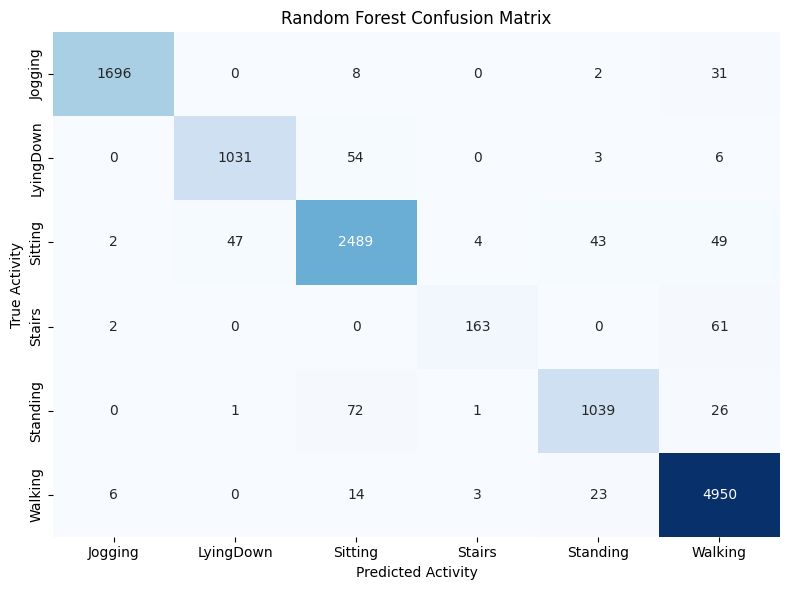

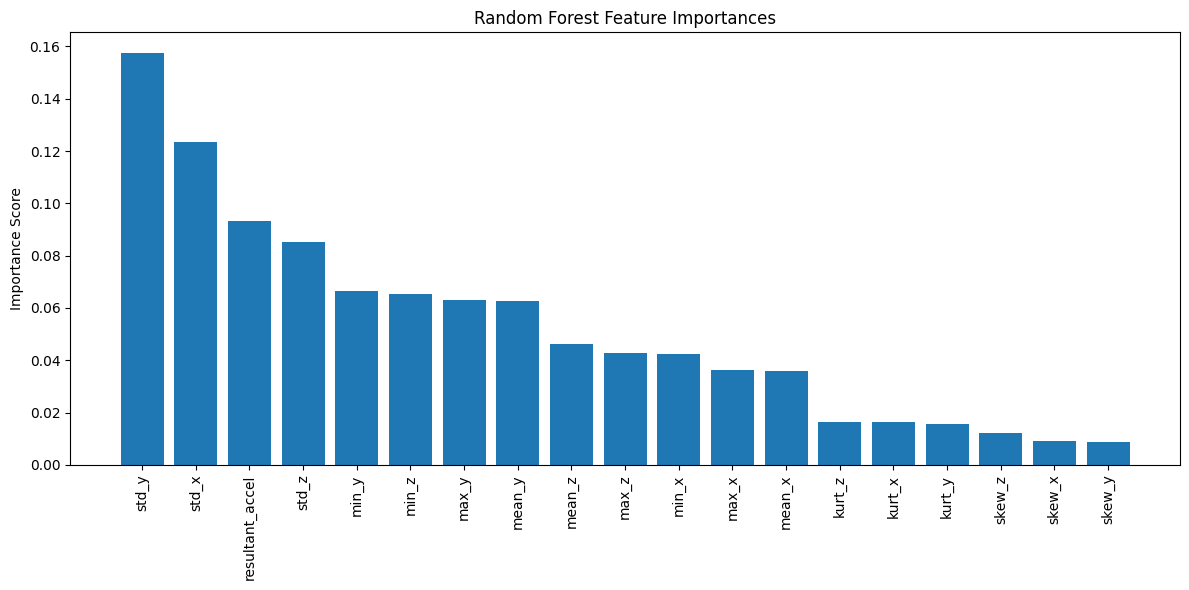

In [18]:

# 1. Plot Confusion Matrix for Random Forest
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_rf = rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred_rf, labels=rf.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted Activity')
plt.ylabel('True Activity')
plt.title('Random Forest Confusion Matrix')
plt.tight_layout()
plt.show()

# 2. Feature Importances Plot for Random Forest
import numpy as np

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.title('Random Forest Feature Importances')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()
